<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Sommaire</h3>

* [1. Preprocessing](#1)
    - [1.1 Imputation des valeur manquantes](#1.1)
* [2. Modèle Baseline : Régression logistique](#2.2)
    - [2.1 Avec l'Oversampling Data Using SMOTE](#2.1)
* [3. Modèle non-linéaires : Arbre de Décision et RandomForest](#3)
    - [3.1 Modèle Arbre de Décision](#3.1)
    - [3.2 Modèle RandomForest](#3.2)
* [4. Feature Selection - Recursive Feature Elimination](#4)
* [5. La fonction coût du modéle](#5)
* [6. Conclusion](#6)
* [7. Annex](#7)
    - [7.1 Libraries](#7.1)


    

<a id="1"></a>
<font color="blue" size=+2.5><b>1 Introduction</b></font>

### Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

<a id="7.1"></a>
<font color="blue" size=+1.5><b>7.1 Libraries</b></font>

In [2]:
# Standard libs
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 100)
import os
import pickle
from zipfile import ZipFile



# Utilities
from utils.viz_utils import *
from utils.custom_transformers import *
from utils.ml_utils import *


# Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Setting of plot : 
set_config(display="diagram")
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

<a id="1"></a>
<font color="darkblue" size=+2.5><b>1. Preprocessing </b></font>

Pour des soucies de vitesse de calcule nous allons réduire notre jeux de client a seulement **30 000** individue.

In [12]:
# Chargement des données : 
z = ZipFile("data/data_train.zip")
data_train = pd.read_table(z.open('data_train.csv'), sep=',' , encoding ='utf-8', index_col='SK_ID_CURR',nrows=30000)
print(f'Notre dataset a pour dimension: {data_train.shape[0]} client et {data_train.shape[1]} features')
display(data_train.head())

Notre dataset a pour dimension: 30000 client et 261 features


CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.090032   
100003               0.0          0.002089    0.311736     0.132924   
100004               0.0          0.000358    0.022472     0.020025   
100006               0.0          0.000935    0.066837     0.109477   
100007               0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.888839   
100003             0.271605                    0.045016    0.477114   
100004             0.023569                    0.134897    0.348534   
100006             0.063973                    0.107023    0.350846   
100007             0.117845                    0.392880    0.298591   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                                                                  
100002           0.045086           0.852140         0.705433         1.0   
100003           0.043648           0.951929         0.959566         1.0   
100004           0.046161           0.827335         0.648326         1.0   
100006           0.038817           0.601451         0.661387         1.0   
100007           0.038820           0.825268         0.519522         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                 1.0              0.0               1.0         1.0   
100003                 1.0              0.0               1.0         1.0   
100004                 1.0              1.0               1.0         1.0   
100006                 1.0              0.0               1.0         0.0   
100007                 1.0              0.0               1.0         0.0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002             0.0         0.000000                   0.5   
100003             0.0         0.052632                   0.0   
100004             0.0         0.000000                   0.5   
100006             0.0         0.052632                   0.5   
100007             0.0         0.000000                   0.5   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                              0.5                 0.434783   
100003                              0.0                 0.478261   
100004                              0.5                 0.391304   
100006                              0.5                 0.739130   
100007                              0.5                 0.478261   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                             0.0                         0.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100006                             0.0                         0.0   
100007                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                              0.0                     0.0   
100003                              0.0                     0.0   
100004                              0.0                     0.0   
100006                              0.0                     0.0   
100007                              0.0                     0.0   

            REG_CITY_NOT_WORK_CITY  LIVE_C

In [13]:
TARGET = pd.read_table('./data/TARGET.csv', sep=',', encoding ='utf-8', index_col='SK_ID_CURR',nrows=30000)
print(f'Notre TARGET a pour dimension: {TARGET.shape[0]} client et {TARGET.shape[1]} features')
display(TARGET.head())

Notre TARGET a pour dimension: 30000 client et 1 features


TARGET
SK_ID_CURR        
100002         1.0
100003         0.0
100004         0.0
100006         0.0
100007         0.0

<a id="1.1"></a>
<font color="blue" size=+1.5><b>1.1 Imputation des valeurs manquantes </b></font>

L'une des approches les plus simples consiste à remplacer les NaN par la Médiane (ou Moyenne) pour les variables correspondantes.



In [14]:
print('Missing values in train data: ', sum(data_train.isnull().sum()))
X = data_train.copy()

Missing values in train data:  1117741


In [15]:
# Splitting the data by dtype
num_features = [col for col, dtype in data_train.dtypes.items() if dtype != 'object']

# Building a numerical pipeline
num_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy='median'))
])


# Building a complete pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features)
])

In [16]:
X = full_pipeline.fit_transform(X)


In [17]:
X.shape

(30000, 251)



#### Dans cette partie nous allons faire diviser notre dataset :


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, TARGET.values, test_size=0.3, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 251), (9000, 251), (21000, 1), (9000, 1))

<a id="2"></a>
<font color="darkblue" size=+2.5><b>2 Baseline model - Logistic Regression </b></font>


Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [20]:
# Logistic Regression hyperparameters   
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 5),
    'penalty': ['l1', 'l2','elasticnet'],
    'class_weight': ['balanced', None],
    'random_state': [22],
    'solver': ['saga']
}
mlr_grid_cv = RandomizedSearchCV(LogisticRegression(), logreg_param_grid, scoring='roc_auc', cv=5, verbose=5, n_jobs=-1)
mlr_grid_cv.fit(X_train, y_train)
best_logreg_params = mlr_grid_cv.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/

[CV 3/5] END C=7.525, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.2s
[CV 2/5] END C=7.525, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.2s
[CV 1/5] END C=7.525, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.2s
[CV 5/5] END C=7.525, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=7.525, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/l

[CV 1/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.726 total time=   9.9s
[CV 3/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.753 total time=   9.8s
[CV 2/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.740 total time=   9.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/l

[CV 3/5] END C=5.05, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.753 total time=  13.7s
[CV 2/5] END C=5.05, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.741 total time=  13.8s
[CV 5/5] END C=5.05, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.722 total time=  13.9s
[CV 4/5] END C=5.05, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.742 total time=  13.9s
[CV 1/5] END C=5.05, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.726 total time=  13.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear

[CV 4/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.742 total time=  10.0s
[CV 1/5] END C=2.575, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.728 total time=  10.1s
[CV 5/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.722 total time=  10.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A co

[CV 2/5] END C=2.575, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.739 total time=  10.2s
[CV 3/5] END C=2.575, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.753 total time=  10.2s
[CV 5/5] END C=2.575, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.723 total time=  10.2s
[CV 4/5] END C=2.575, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.741 total time=  10.2s
[CV 1/5] END C=0.1, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s[CV 2/5] END C=0.1, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s

[CV 4/5] END C=0.1, class_weight=None, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, penalty=elasticnet, rando

/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear

[CV 1/5] END C=7.525, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.706 total time=  13.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/l

[CV 2/5] END C=7.525, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.729 total time=  14.0s
[CV 4/5] END C=7.525, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.730 total time=  13.9s
[CV 3/5] END C=7.525, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.748 total time=  14.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[CV 1/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.723 total time=  12.9s
[CV 2/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.714 total time=  13.0s
[CV 3/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.740 total time=  13.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=7.525, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.708 total time=  13.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.732 total time=  13.4s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.703 total time=  10.6s
[CV 2/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.726 total time=  10.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ 

[CV 5/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.704 total time=  13.5s
[CV 3/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.740 total time=  10.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.734 total time=  10.7s
[CV 5/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.712 total time=  10.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=7.525, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.709 total time=  10.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=7.525, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.728 total time=   9.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=7.525, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.747 total time=   7.3s
[CV 4/5] END C=7.525, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.723 total time=   7.2s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=7.525, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.717 total time=   5.8s


AUC : 0.7403
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     11048
         1.0       0.47      0.02      0.05       952

    accuracy                           0.92     12000
   macro avg       0.70      0.51      0.50     12000
weighted avg       0.89      0.92      0.89     12000

LogisticRegression:


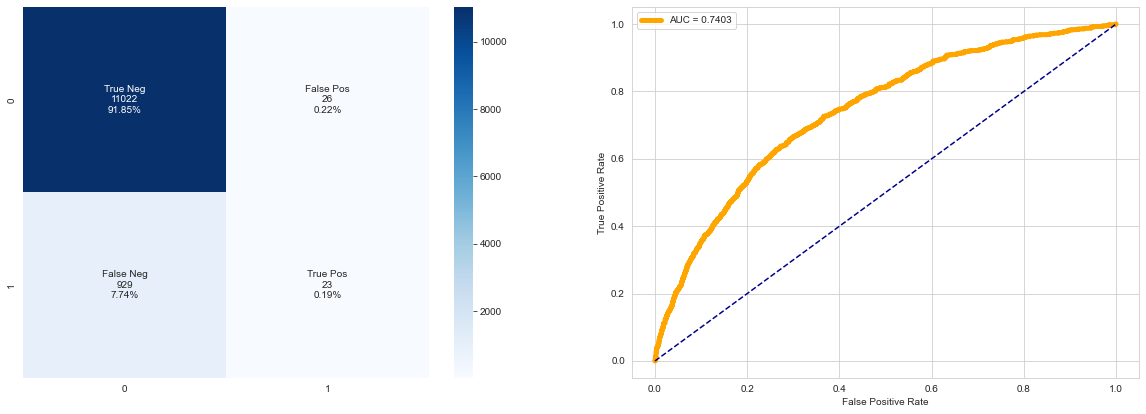

In [21]:

mlr = LogisticRegression(**best_logreg_params)
mlr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mlr.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mlr.predict(X_test)))
print("=="*50)
print('LogisticRegression:')
cf_matrix_roc_auc(mlr, y_test, mlr.predict(X_test), mlr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..



<a id="2.1"></a>
<font color="blue" size=+1.5><b>2.1 Oversampling Data Using SMOTE </b></font>

Il est donc intéressant de travailler cet **Oversampling (ou suréchantillonnage en français)**  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire

In [22]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: [2279] 
Label 0, Before using SMOTE: [25721] 


In [23]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [24]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 25721
Label 0, After using SMOTE: 25721


In [25]:
mlr_grid_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END C=5.05, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.5s
[CV 3/5] END C=5.05, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.5s
[CV 1/5] END C=5.05, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.5s
[CV 2/5] END C=5.05, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.5s
[CV 4/5] END C=5.05, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.802 total time=  19.0s
[CV 2/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.797 total time=  19.0s
[CV 1/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.768 total time=  19.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=2.575, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.797 total time=  26.3s
[CV 3/5] END C=2.575, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.802 total time=  26.3s
[CV 1/5] END C=2.575, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.768 total time=  26.5s
[CV 5/5] END C=2.575, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.794 total time=  25.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=2.575, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.794 total time=  26.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.1s
[CV 5/5] END C=5.05, class_weight=balanced, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10.0, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.769 total time=  26.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The ma

[CV 5/5] END C=10.0, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.794 total time=  26.7s
[CV 4/5] END C=10.0, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.795 total time=  26.7s
[CV 2/5] END C=10.0, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.798 total time=  26.9s
[CV 3/5] END C=10.0, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.803 total time=  26.9s
[CV 1/5] END C=5.05, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.769 total time=  26.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=5.05, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.798 total time=  26.8s
[CV 3/5] END C=5.05, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.803 total time=  26.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The ma

[CV 2/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.797 total time=  19.5s
[CV 4/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.5s
[CV 3/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.802 total time=  19.5s
[CV 4/5] END C=5.05, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.795 total time=  26.5s
[CV 1/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.768 total time=  19.6s
[CV 1/5] END C=10.0, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.1s
[CV 2/5] END C=10.0, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.1s
[CV 3/5] END C=10.0, class_weight=balanced, penalty=elasticnet, random_state=22, solver=saga;, score=nan total time=   0.1s
[CV 4/5] END C=10.0, class_weight=balanced, penalty=el

/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=5.05, class_weight=balanced, penalty=l1, random_state=22, solver=saga;, score=0.794 total time=  26.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=5.05, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.2s
[CV 1/5] END C=7.525, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.768 total time=  19.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=7.525, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.802 total time=  19.4s
[CV 4/5] END C=7.525, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.4s
[CV 2/5] END C=7.525, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.797 total time=  19.5s
[CV 5/5] END C=7.525, class_weight=None, penalty=l2, random_state=22, solver=saga;, score=0.794 total time=  19.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=7.525, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.769 total time=  23.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=7.525, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.798 total time=  22.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=7.525, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.795 total time=  19.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=7.525, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.803 total time=  20.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=7.525, class_weight=None, penalty=l1, random_state=22, solver=saga;, score=0.794 total time=  16.7s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([ 0.1  ,  2.575,  5.05 ,  7.525, 10.   ]),
                                        'class_weight': ['balanced', None],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'random_state': [22],
                                        'solver': ['saga']},
                   scoring='roc_auc', verbose=5)

AUC : 0.7308
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     11048
         1.0       0.16      0.64      0.26       952

    accuracy                           0.71     12000
   macro avg       0.56      0.68      0.54     12000
weighted avg       0.89      0.71      0.77     12000

LogisticRegression:


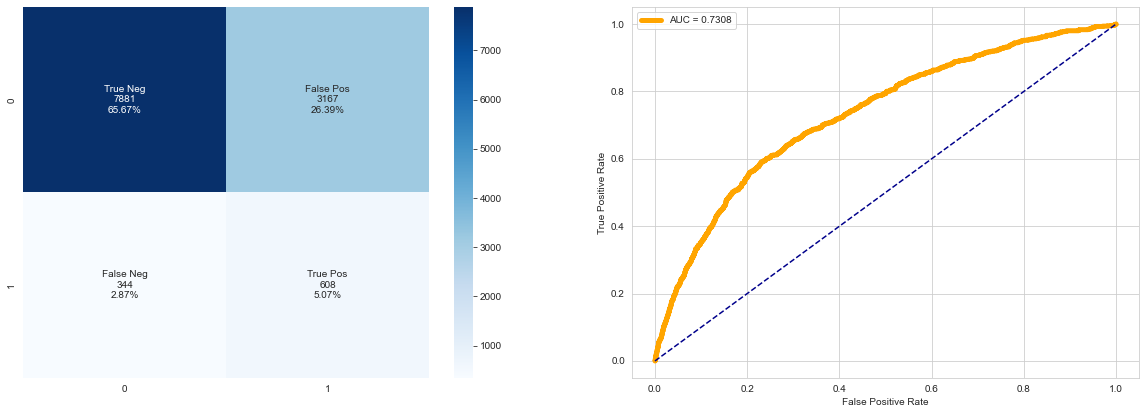

In [26]:
mlr_res = LogisticRegression(**mlr_grid_cv.best_params_)
mlr_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mlr_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mlr_res.predict(X_test)))
print("=="*50)
print('LogisticRegression:')
cf_matrix_roc_auc(mlr_res, y_test, mlr_res.predict(X_test), mlr_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

Nous avons fait baisser **AUC score** de **2** en utilisent la technique de **SMOTE**


<a id="3"></a>
<font color="darkblue" size=+2.5><b> 3. Model :RandomForest et Arbre de décision </b></font>
* <a id="3.1"></a>
    <font color="blue" size=+1.5><b>3.1 Arbre de décision </b></font>



In [27]:
# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}
mdtc_grid_cv = RandomizedSearchCV(DecisionTreeClassifier(), tree_param_grid , scoring='roc_auc', cv=5, verbose=5, n_jobs=-1)
mdtc_grid_cv.fit(X_train, y_train)
best_tree_params = mdtc_grid_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END class_weight=None, criterion=entropy, max_depth=10, max_features=145, random_state=42;, score=0.617 total time=   1.9s
[CV 3/5] END class_weight=None, criterion=entropy, max_depth=10, max_features=145, random_state=42;, score=0.619 total time=   1.8s
[CV 2/5] END class_weight=None, criterion=entropy, max_depth=10, max_features=145, random_state=42;, score=0.618 total time=   1.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=20, max_features=222, random_state=42;, score=0.568 total time=   3.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=20, max_features=222, random_state=42;, score=0.587 total time=   3.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=20, max_features=222, random_state=42;, score=0.574 total time=   3.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=20, max_features=222, random_state=42;, score=0.569 total time=   3.1s
[CV 5/5] EN

AUC : 0.6753
              precision    recall  f1-score   support

         0.0       0.96      0.57      0.72     11048
         1.0       0.12      0.70      0.21       952

    accuracy                           0.58     12000
   macro avg       0.54      0.64      0.46     12000
weighted avg       0.89      0.58      0.68     12000

DecisionTreeClassifier():


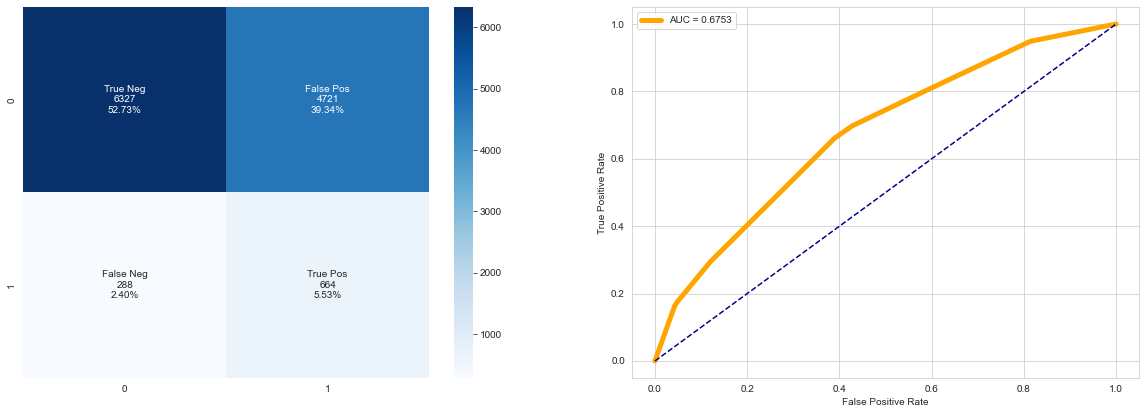

In [28]:
mdtc = DecisionTreeClassifier(**best_tree_params)
mdtc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mdtc.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mdtc.predict(X_test)))
print("=="*50)
print('DecisionTreeClassifier():')
cf_matrix_roc_auc(mdtc, y_test, mdtc.predict(X_test), mdtc.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _SMOTE_
____

In [29]:
mdtc_grid_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END class_weight=None, criterion=gini, max_depth=5, max_features=14, random_state=42;, score=0.782 total time=   0.5s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=5, max_features=14, random_state=42;, score=0.694 total time=   0.5s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=5, max_features=14, random_state=42;, score=0.767 total time=   0.5s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=39, random_state=42;, score=0.764 total time=   0.6s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=39, random_state=42;, score=0.762 total time=   0.7s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=39, random_state=42;, score=0.758 total time=   0.7s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=39, random_state=42;, score=0.683 total time=   0.7s
[CV 2/5] END class_weight=balanced

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,...
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250]),
                                        'random_state': [42]},
                   scoring='roc_auc', verbose=5)

AUC : 0.6207
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     11048
         1.0       0.14      0.17      0.15       952

    accuracy                           0.85     12000
   macro avg       0.53      0.54      0.53     12000
weighted avg       0.86      0.85      0.86     12000

DecisionTreeClassifier():


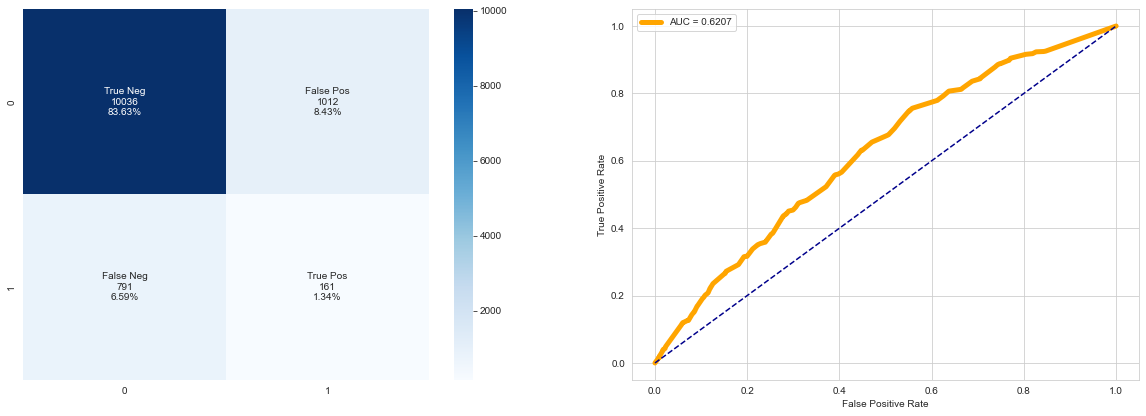

In [30]:
mdtc_res = DecisionTreeClassifier(**mdtc_grid_cv.best_params_)
mdtc_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mdtc_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mdtc_res.predict(X_test)))
print("=="*50)
print('DecisionTreeClassifier():')
cf_matrix_roc_auc(mdtc_res, y_test, mdtc_res.predict(X_test), mdtc_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

<a id="3.2"></a>
    <font color="blue" size=+1.5><b>3.2 RandomForest </b></font>


In [20]:
# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [22],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

mrf_grid_cv = RandomizedSearchCV(RandomForestClassifier(), forest_param_grid , scoring='roc_auc', cv=5, verbose=5, n_jobs=-1)
mrf_grid_cv.fit(X_train, y_train)
best_forest_params = mrf_grid_cv.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskheredd

[CV 1/5] END bootstrap=False, class_weight=None, max_depth=10, max_features=auto, n_estimators=100, random_state=22;, score=0.731 total time=  11.7s
[CV 2/5] END bootstrap=False, class_weight=None, max_depth=10, max_features=auto, n_estimators=100, random_state=22;, score=0.745 total time=  11.7s
[CV 3/5] END bootstrap=False, class_weight=None, max_depth=10, max_features=auto, n_estimators=100, random_state=22;, score=0.715 total time=  11.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.687 total time=  21.5s
[CV 3/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.707 total time=  21.5s
[CV 1/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.704 total time=  21.5s
[CV 4/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.689 total time=  21.6s
[CV 2/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.737 total time=  21.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskheredd

[CV 1/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=sqrt, n_estimators=50, random_state=22;, score=0.727 total time=   2.4s
[CV 5/5] END bootstrap=False, class_weight=None, max_depth=10, max_features=auto, n_estimators=100, random_state=22;, score=0.717 total time=  12.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=None, max_depth=10, max_features=auto, n_estimators=100, random_state=22;, score=0.710 total time=  12.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=sqrt, n_estimators=50, random_state=22;, score=0.729 total time=   2.4s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=sqrt, n_estimators=50, random_state=22;, score=0.713 total time=   2.4s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=sqrt, n_estimators=50, random_state=22;, score=0.694 total time=   2.4s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, n_estimators=200, random_state=22;, score=0.736 total time=  16.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=sqrt, n_estimators=50, random_state=22;, score=0.709 total time=   2.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, n_estimators=50, random_state=22;, score=0.718 total time=   6.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, n_estimators=50, random_state=22;, score=0.728 total time=   6.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, n_estimators=50, random_state=22;, score=0.707 total time=   6.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, n_estimators=50, random_state=22;, score=0.708 total time=   6.2s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, n_estimators=200, random_state=22;, score=0.708 total time=  16.8s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, n_estimators=200, random_state=22;, score=0.744 total time=  16.9s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, n_estimators=200, random_state=22;, score=0.717 total time=  16.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=None, max_depth=10, max_features=sqrt, n_estimators=200, random_state=22;, score=0.718 total time=  17.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=balanced, max_depth=10, max_features=auto, n_estimators=50, random_state=22;, score=0.690 total time=   6.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.686 total time=  11.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.709 total time=  12.0s
[CV 3/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.681 total time=  11.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.687 total time=  11.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.672 total time=  11.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=100, random_state=22;, score=0.707 total time=   4.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=100, random_state=22;, score=0.728 total time=   4.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=100, random_state=22;, score=0.699 total time=   4.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=100, random_state=22;, score=0.673 total time=   4.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=100, random_state=22;, score=0.683 total time=   4.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=200, random_state=22;, score=0.732 total time=  34.9s
[CV 1/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=200, random_state=22;, score=0.726 total time=  35.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=200, random_state=22;, score=0.717 total time=  35.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=200, random_state=22;, score=0.697 total time=  35.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=200, random_state=22;, score=0.688 total time=  35.0s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.720 total time=  29.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.730 total time=  30.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.715 total time=  15.3s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.689 total time=  31.0s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.736 total time=  14.4s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.705 total time=  13.8s
[CV 4/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.680 total time=  12.8s
[CV 5/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=500, random_state=22;, score=0.695 total time=  12.0s
[CV 5/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, 

AUC : 0.7289
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84     11048
         1.0       0.17      0.59      0.26       952

    accuracy                           0.73     12000
   macro avg       0.56      0.67      0.55     12000
weighted avg       0.89      0.73      0.79     12000

RandomForestClassifier:


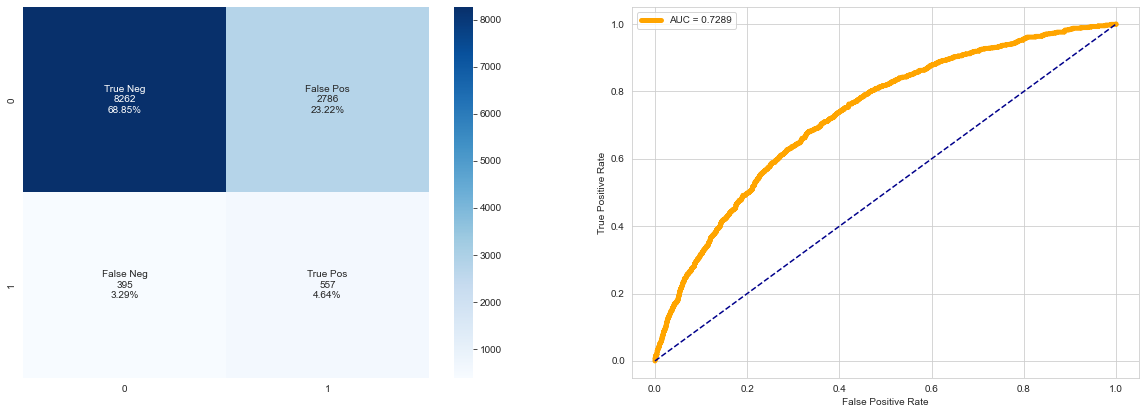

In [32]:
mrf = RandomForestClassifier(**best_forest_params)
mrf.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mrf.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mrf.predict(X_test)))
print("=="*50)
print('RandomForestClassifier:')
cf_matrix_roc_auc(mrf, y_test, mrf.predict(X_test), mrf.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _SMOTE_
____

In [23]:
mrf_grid_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=1.000 total time=  29.7s
[CV 5/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.999 total time=  30.0s
[CV 2/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=1.000 total time=  30.3s
[CV 3/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=1.000 total time=  30.4s
[CV 1/5] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=50, random_state=22;, score=0.947 total time=  30.7s
[CV 1/5] END bootstrap=False, class_weight=None, max_depth=20, max_features=sqrt, n_estimators=50, random_state=22;, score=0.939 total time=  26.9s
[CV 2/5] END bootstrap=False, c

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'max_depth': [3, 5, 10, 20, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 100, 200, 500],
                                        'random_state': [22]},
                   scoring='roc_auc', verbose=5)

AUC : 0.6979
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     11048
         1.0       0.23      0.03      0.06       952

    accuracy                           0.91     12000
   macro avg       0.58      0.51      0.51     12000
weighted avg       0.87      0.91      0.88     12000

RandomForestClassifier:


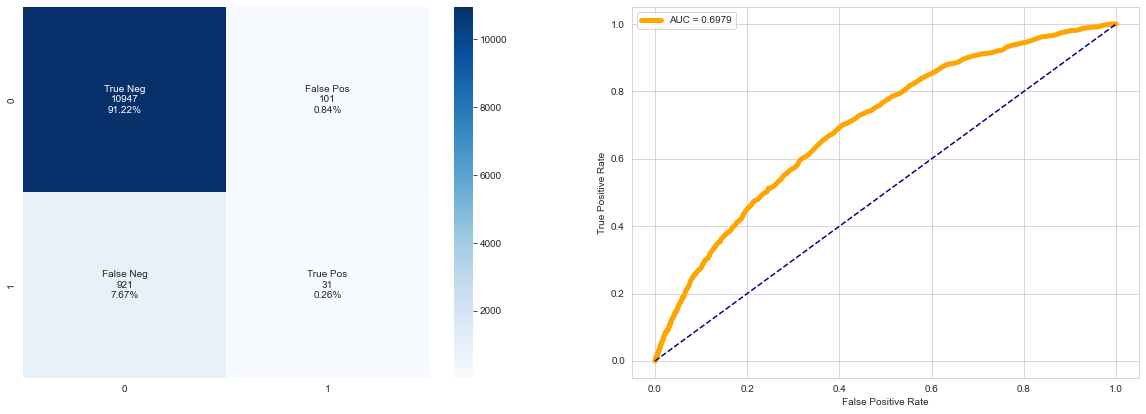

In [24]:
mrf_res = RandomForestClassifier(**mrf_grid_cv.best_params_)
mrf_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mrf_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mrf_res.predict(X_test)))
print("=="*50)
print('RandomForestClassifier:')
cf_matrix_roc_auc(mrf_res, y_test, mrf_res.predict(X_test), mrf_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _Recapitulatif_
____

In [26]:
models = [
         LogisticRegression(**best_logreg_params),
         DecisionTreeClassifier(**best_tree_params),
         RandomForestClassifier(**best_forest_params)]

In [27]:
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = classify_train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

In [28]:
base_models.reset_index(drop=True).style.background_gradient(cmap='Blues')

<a id="4"></a>
<font color="darkblue" size=+2.5><b>4. Feature Selection - Recursive Feature Elimination </b></font>

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec `RandomForest` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent **`261 features`**, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [21]:
start = time.time()
rfecv = RFECV(estimator=RandomForestClassifier(**best_forest_params), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 251 features.
Fitting estimator with 251 features.
Fitting estimator with 251 features.
Fitting estimator with 251 features.
Fitting estimator with 251 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anac

Fitting estimator with 246 features.
Fitting estimator with 246 features.
Fitting estimator with 246 features.
Fitting estimator with 246 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anac

Fitting estimator with 246 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 241 features.
Fitting estimator with 241 features.
Fitting estimator with 241 features.
Fitting estimator with 241 features.
Fitting estimator with 241 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anac

Fitting estimator with 236 features.
Fitting estimator with 236 features.
Fitting estimator with 236 features.
Fitting estimator with 236 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anac

Fitting estimator with 236 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 231 features.
Fitting estimator with 231 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 231 features.
Fitting estimator with 231 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 231 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 226 features.
Fitting estimator with 226 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 226 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 226 features.
Fitting estimator with 226 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 221 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 221 features.
Fitting estimator with 221 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 221 features.
Fitting estimator with 221 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 216 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 216 features.
Fitting estimator with 216 features.
Fitting estimator with 216 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 216 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 211 features.
Fitting estimator with 211 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 211 features.
Fitting estimator with 211 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 211 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 206 features.
Fitting estimator with 206 features.
Fitting estimator with 206 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 206 features.
Fitting estimator with 206 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 201 features.
Fitting estimator with 201 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 201 features.
Fitting estimator with 201 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 201 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 196 features.
Fitting estimator with 196 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 196 features.
Fitting estimator with 196 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 196 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 191 features.
Fitting estimator with 191 features.
Fitting estimator with 191 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 191 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 191 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 186 features.
Fitting estimator with 186 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 186 features.
Fitting estimator with 186 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 186 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 181 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 181 features.
Fitting estimator with 181 features.
Fitting estimator with 181 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 181 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 176 features.
Fitting estimator with 176 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 176 features.
Fitting estimator with 176 features.
Fitting estimator with 176 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 171 features.
Fitting estimator with 171 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 171 features.
Fitting estimator with 171 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 171 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 166 features.
Fitting estimator with 166 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 166 features.
Fitting estimator with 166 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 166 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 161 features.
Fitting estimator with 161 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 161 features.
Fitting estimator with 161 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 161 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 156 features.
Fitting estimator with 156 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 156 features.
Fitting estimator with 156 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 156 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 151 features.
Fitting estimator with 151 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 151 features.
Fitting estimator with 151 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 151 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 146 features.
Fitting estimator with 146 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 146 features.
Fitting estimator with 146 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 146 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 141 features.
Fitting estimator with 141 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 141 features.
Fitting estimator with 141 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 141 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 136 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 136 features.
Fitting estimator with 136 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 136 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 136 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 131 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 131 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 131 features.
Fitting estimator with 131 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 131 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 126 features.
Fitting estimator with 126 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 126 features.
Fitting estimator with 126 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 126 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 121 features.
Fitting estimator with 121 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 121 features.
Fitting estimator with 121 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 121 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 116 features.
Fitting estimator with 116 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 116 features.
Fitting estimator with 116 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 116 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 111 features.
Fitting estimator with 111 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 111 features.
Fitting estimator with 111 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 111 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 106 features.
Fitting estimator with 106 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 106 features.
Fitting estimator with 106 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 106 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 101 features.
Fitting estimator with 101 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 101 features.
Fitting estimator with 101 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 101 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 96 features.
Fitting estimator with 96 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 96 features.
Fitting estimator with 96 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 96 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 91 features.
Fitting estimator with 91 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 91 features.
Fitting estimator with 91 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 91 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 86 features.
Fitting estimator with 86 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 86 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 86 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 86 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 81 features.
Fitting estimator with 81 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 81 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 81 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 81 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 76 features.
Fitting estimator with 76 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 76 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 76 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 76 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 71 features.
Fitting estimator with 71 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 71 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 71 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 71 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 66 features.
Fitting estimator with 66 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 66 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 66 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 66 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 61 features.
Fitting estimator with 61 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 61 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 61 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 61 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 56 features.
Fitting estimator with 56 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 56 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 56 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 56 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 51 features.
Fitting estimator with 51 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 51 features.
Fitting estimator with 51 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 51 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 46 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 46 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 41 features.
Fitting estimator with 41 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 41 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 41 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 41 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 36 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 36 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 36 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 36 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 36 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 31 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 31 features.
Fitting estimator with 31 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 31 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 31 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 26 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 26 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 26 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 26 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 26 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 21 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 21 features.
Fitting estimator with 21 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 21 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 21 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 16 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 16 features.
Fitting estimator with 16 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 16 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 16 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 11 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 11 features.
Fitting estimator with 11 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 11 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 11 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 6 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 6 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 6 features.
Fitting estimator with 6 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)


Fitting estimator with 6 features.


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
/Users/yaniskheredd

Fitting estimator with 251 features.
Fitting estimator with 246 features.
Fitting estimator with 241 features.
Fitting estimator with 236 features.
Fitting estimator with 231 features.
Fitting estimator with 226 features.
Fitting estimator with 221 features.
Fitting estimator with 216 features.
Fitting estimator with 211 features.
Fitting estimator with 206 features.
Fitting estimator with 201 features.
Fitting estimator with 196 features.
Fitting estimator with 191 features.
Fitting estimator with 186 features.
Fitting estimator with 181 features.
Fitting estimator with 176 features.
Fitting estimator with 171 features.
Fitting estimator with 166 features.
Fitting estimator with 161 features.
Fitting estimator with 156 features.
Fitting estimator with 151 features.
Fitting estimator with 146 features.
Fitting estimator with 141 features.
Fitting estimator with 136 features.
Fitting estimator with 131 features.
Time Elapsed: 918.1640391349792


In [22]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("=="*50)
print("Selected Features: %s" % rfecv.support_[:25])
print("=="*50)
print("Feature Ranking : %s" % rfecv.ranking_[:25])

Optimal number of features : 126
Selected Features: [ True  True  True  True  True  True  True  True  True  True False False
  True False  True False  True  True  True  True False False False  True
  True]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1  1 22  2  1 23  1  6  1  1  1  1 11  8 12  1
  1]


RFECV conserve les features avec un **`Rank 1 > True`**. Ci-dessous une vérification de la sélection de Rank 1…

In [23]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = pd.Series(np.asarray(rfecv.ranking_))
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

126
['CNT_CHILDREN', 'PREV_APPL_MEAN_RATE_INTEREST_PRIMARY', 'PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 'PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 'PREV_BUR_MEAN_CNT_CREDIT_PROLONG', 'PREV_BUR_MEAN_AMT_CREDIT_SUM', 'PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 'PREV_BUR_MEAN_A

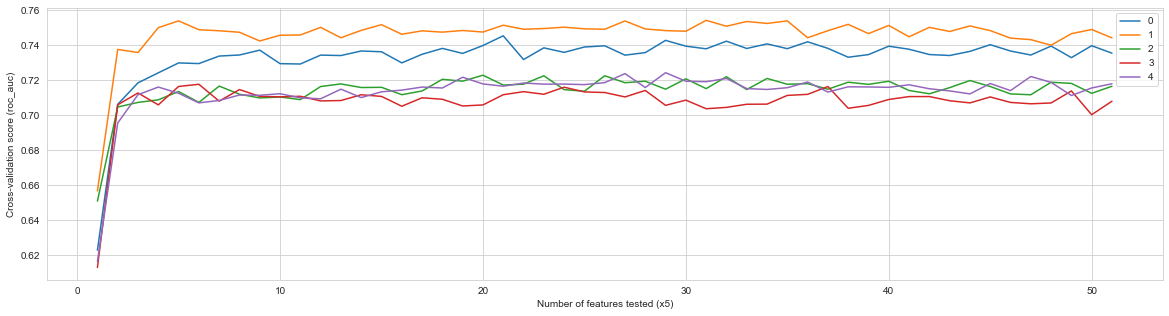

In [24]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.legend(['0','1','2','3','4'])
plt.show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [25]:
data_train.iloc[:X_train.shape[0],:X.shape[1]]

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002          0.000000          0.001512    0.090287     0.090032   
100003          0.000000          0.002089    0.311736     0.132924   
100004          0.000000          0.000358    0.022472     0.020025   
100006          0.000000          0.000935    0.066837     0.109477   
100007          0.000000          0.000819    0.116854     0.078975   
...                  ...               ...         ...          ...   
124467          0.000000          0.001704    0.261343     0.163057   
124468          0.105263          0.001704    0.050876     0.109337   
124469          0.052632          0.000742    0.161303     0.098631   
124470          0.000000          0.001050    0.190674     0.086416   
124471          0.105263          0.001704    0.044944     0.037575   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.888839   
100003             0.271605                    0.045016    0.477114   
100004             0.023569                    0.134897    0.348534   
100006             0.063973                    0.107023    0.350846   
100007             0.117845                    0.392880    0.298591   
...                     ...                         ...         ...   
124467             0.223345                    0.090864    0.599098   
124468             0.046016                    0.635991    0.817249   
124469             0.113356                    0.256321    0.877959   
124470             0.158249                    0.245631    0.355806   
124471             0.046016                    0.276330    0.543630   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                                                                  
100002           0.045086           0.852140         0.705433         1.0   
100003           0.043648           0.951929         0.959566         1.0   
100004           0.046161           0.827335         0.648326         1.0   
100006           0.038817           0.601451         0.661387         1.0   
100007           0.038820           0.825268         0.519522         1.0   
...                   ...                ...              ...         ...   
124467           0.046229           0.828713         0.385299         1.0   
124468           0.042685           0.992745         0.684313         1.0   
124469           0.039000           0.608706         0.826039         1.0   
124470           1.000000           0.833658         0.658747         1.0   
124471           0.039477           0.853478         0.334862         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                 1.0              0.0               1.0         1.0   
100003                 1.0              0.0               1.0         1.0   
100004                 1.0              1.0               1.0         1.0   
100006                 1.0              0.0               1.0         0.0   
100007                 1.0              0.0               1.0         0.0   
...                    ...              ...               ...         ...   
124467                 1.0              0.0               1.0         0.0   
124468                 1.0              0.0               1.0         0.0   
124469                 1.0              1.0               1.0         1.0   
124470                 0.0              0.0               1.0         0.0   
124471                 1.0              0.0               1.0         1.0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002             0.0        

In [26]:
#X_data is very important to implement the feature importance plot...
X_data = pd.DataFrame(X,columns=data_train.columns[:X.shape[1]],index=data_train.index[:X.shape[0]])
X_data = X_data[features_selection]
print("Dimension de X_data:")
display(X_data.shape)
print("=="*50)
print("X_data head:")
display(X_data.head())

Dimension de X_data:


(30000, 126)

X_data head:


CNT_CHILDREN  PREV_APPL_MEAN_RATE_INTEREST_PRIMARY  \
SK_ID_CURR                                                       
100002               0.0                              0.000000   
100003               0.0                              0.666667   
100004               0.0                              0.000000   
100006               0.0                              0.000000   
100007               0.0                              0.600000   

            PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED  \
SK_ID_CURR                                            
100002                                     0.816327   
100003                                     0.816327   
100004                                     0.816327   
100006                                     0.948980   
100007                                     0.816327   

            PREV_APPL_MEAN_DAYS_DECISION  PREV_APPL_MEAN_SELLERPLACE_AREA  \
SK_ID_CURR                                                                  
100002                          0.029731                         0.119048   
100003                          0.029731                         0.119048   
100004                          0.029731                         0.119048   
100006                          0.003145                         0.200000   
100007                          0.029731                         0.119048   

            PREV_APPL_MEAN_CNT_PAYMENT  PREV_APPL_MEAN_DAYS_FIRST_DRAWING  \
SK_ID_CURR                                                                  
100002                        0.006728                           0.003646   
100003                        0.006728                           0.003646   
100004                        0.006728                           0.003646   
100006                        0.006728                           0.000000   
100007                        0.006728                           0.003646   

            PREV_APPL_MEAN_DAYS_FIRST_DUE  \
SK_ID_CURR                                  
100002                                0.0   
100003                                0.0   
100004                                0.0   
100006                                0.0   
100007                                0.0   

            PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION  \
SK_ID_CURR                                             
100002                                       0.00111   
100003                                       0.00111   
100004                                       0.00111   
100006                                       0.00111   
100007                                       0.00111   

            PREV_APPL_MEAN_DAYS_LAST_DUE  PREV_APPL_MEAN_DAYS_TERMINATION  \
SK_ID_CURR                                                                  
100002                          0.036239                         0.010371   
100003                          0.036239                         0.010371   
100004                          0.036239                         0.010371   
100006                          0.000000                         0.010371   
100007                          0.036239                         0.010371   

            PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL  \
SK_ID_CURR                                             
100002                                      0.003719   
100003                                      0.003719   
100004                                      0.003719   
100006                                      0.000000   
100007                                      0.003719   

            PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE  \
SK_ID_CURR                                            
100002                                     0.030095   
100003                                     0.030095   
100004                                     0.030095   
100006                                     0.003302   
100007                                     0.030095   

            PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE  \
SK_

Il est nécessaire de sauvegarder le dataset **`X_data`** de manière à pouvoir le réutiliser facilement…

In [30]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [32]:
print(f'Nous avons dans notre jeux donner utile {X_data.shape[0]} client et {X_data.shape[1]} qui les caratérise.')
print("=="*50)
display(X_data.head())

Nous avons dans notre jeux donner utile 30000 client et 127 qui les caratérise.


CNT_CHILDREN  PREV_APPL_MEAN_RATE_INTEREST_PRIMARY  \
SK_ID_CURR                                                       
100002               0.0                              0.000000   
100003               0.0                              0.666667   
100004               0.0                              0.000000   
100006               0.0                              0.000000   
100007               0.0                              0.600000   

            PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED  \
SK_ID_CURR                                            
100002                                     0.816327   
100003                                     0.816327   
100004                                     0.816327   
100006                                     0.948980   
100007                                     0.816327   

            PREV_APPL_MEAN_DAYS_DECISION  PREV_APPL_MEAN_SELLERPLACE_AREA  \
SK_ID_CURR                                                                  
100002                          0.029731                         0.119048   
100003                          0.029731                         0.119048   
100004                          0.029731                         0.119048   
100006                          0.003145                         0.200000   
100007                          0.029731                         0.119048   

            PREV_APPL_MEAN_CNT_PAYMENT  PREV_APPL_MEAN_DAYS_FIRST_DRAWING  \
SK_ID_CURR                                                                  
100002                        0.006728                           0.003646   
100003                        0.006728                           0.003646   
100004                        0.006728                           0.003646   
100006                        0.006728                           0.000000   
100007                        0.006728                           0.003646   

            PREV_APPL_MEAN_DAYS_FIRST_DUE  \
SK_ID_CURR                                  
100002                                0.0   
100003                                0.0   
100004                                0.0   
100006                                0.0   
100007                                0.0   

            PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION  \
SK_ID_CURR                                             
100002                                       0.00111   
100003                                       0.00111   
100004                                       0.00111   
100006                                       0.00111   
100007                                       0.00111   

            PREV_APPL_MEAN_DAYS_LAST_DUE  PREV_APPL_MEAN_DAYS_TERMINATION  \
SK_ID_CURR                                                                  
100002                          0.036239                         0.010371   
100003                          0.036239                         0.010371   
100004                          0.036239                         0.010371   
100006                          0.000000                         0.010371   
100007                          0.036239                         0.010371   

            PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL  \
SK_ID_CURR                                             
100002                                      0.003719   
100003                                      0.003719   
100004                                      0.003719   
100006                                      0.000000   
100007                                      0.003719   

            PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE  \
SK_ID_CURR                                            
100002                                     0.030095   
100003                                     0.030095   
100004                                     0.030095   
100006                                     0.003302   
100007                                     0.030095   

            PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE  \
SK_

Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec **`les 146 best features identifiées`**. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [33]:
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('./data/X_sample_30.zip', index=True, compression=compression_opts)

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

$\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}$


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:

$\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}$



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 

$\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}$



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

$\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}$

On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.

Nous allons de nouveau entrainer notre modél **RamdomForest** sur cette fois sur nos features de **RFECV**

In [27]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [128]:
def cf_matrix_roc_auc_not(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''
    This function will make a pretty plot of 
    an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.
    '''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if feature_importances : 
      plt.subplot(212)
      features = []
      indices = np.argsort(model.feature_importances_)[::-1]
      for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

    

In [132]:
mrf_grid_cv.fit(X_train_selected, y_train)
mdtc_grid_cv.fit(X_train_selected, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskheredd

[CV 3/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=auto, n_estimators=50, random_state=22;, score=0.717 total time=   3.8s
[CV 2/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=auto, n_estimators=50, random_state=22;, score=0.704 total time=   3.8s
[CV 1/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=auto, n_estimators=50, random_state=22;, score=0.708 total time=   3.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=auto, n_estimators=50, random_state=22;, score=0.694 total time=   4.2s
[CV 4/5] END bootstrap=False, class_weight=balanced, max_depth=3, max_features=auto, n_estimators=50, random_state=22;, score=0.697 total time=   4.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=100, random_state=22;, score=0.714 total time=  26.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=100, random_state=22;, score=0.701 total time=  26.4s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=100, random_state=22;, score=0.723 total time=  26.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.700 total time=  17.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=100, random_state=22;, score=0.692 total time=  25.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=100, random_state=22;, score=0.691 total time=  25.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.718 total time=  17.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.698 total time=  17.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=auto, n_estimators=50, random_state=22;, score=0.722 total time=   3.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.702 total time=  17.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=auto, n_estimators=50, random_state=22;, score=0.712 total time=   3.6s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=auto, n_estimators=50, random_state=22;, score=0.731 total time=   3.7s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=auto, n_estimators=50, random_state=22;, score=0.707 total time=   3.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=None, max_depth=5, max_features=auto, n_estimators=50, random_state=22;, score=0.699 total time=   3.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.689 total time=  18.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=500, random_state=22;, score=0.723 total time= 2.1min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=500, random_state=22;, score=0.713 total time= 2.2min
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=500, random_state=22;, score=0.729 total time= 2.2min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=500, random_state=22;, score=0.702 total time= 2.2min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=True, class_weight=None, max_depth=50, max_features=sqrt, n_estimators=500, random_state=22;, score=0.693 total time= 2.2min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=200, random_state=22;, score=0.717 total time=   9.0s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=200, random_state=22;, score=0.707 total time=   8.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=200, random_state=22;, score=0.721 total time=   8.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=200, random_state=22;, score=0.695 total time=   9.0s
[CV 5/5] END bootstrap=True, class_weight=None, max_depth=3, max_features=sqrt, n_estimators=200, random_state=22;, score=0.687 total time=   8.8s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=auto, n_estimators=200, random_state=22;, score=0.712 total time=  12.4s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=auto, n_estimators=200, random_state=22;, score=0.715 total time=  12.1s
[CV 2/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=auto, n_estimators=200, random_state=22;, score=0.702 total time=  12.2s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.720 total time= 1.3min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.722 total time= 1.3min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.720 total time= 1.3min


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=auto, n_estimators=200, random_state=22;, score=0.693 total time=  12.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END bootstrap=False, class_weight=None, max_depth=3, max_features=auto, n_estimators=200, random_state=22;, score=0.681 total time=  12.5s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=50, random_state=22;, score=0.683 total time=   9.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=50, random_state=22;, score=0.699 total time=   8.9s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.705 total time=  38.1s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=50, random_state=22;, score=0.684 total time=   8.3s


/Users/yaniskhereddine/opt/anaconda3/envs/P7_OC_ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.710 total time=  38.8s
[CV 3/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.708 total time=  38.7s
[CV 4/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.707 total time=  38.2s
[CV 4/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=200, random_state=22;, score=0.704 total time= 1.3min
[CV 4/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=50, random_state=22;, score=0.686 total time=   7.1s
[CV 5/5] END bootstrap=False, class_weight=None, max_depth=50, max_features=auto, n_estimators=100, random_state=22;, score=0.672 total time=  38.2s
[CV 5/5] END bootstrap=True, class_weight=balanced, max_depth=50, max_features=sqrt, n_estimators=50, ra

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,...
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250]),
                                        'random_state': [42]},
                   scoring='roc_auc', verbose=5)

AUC : 0.7227


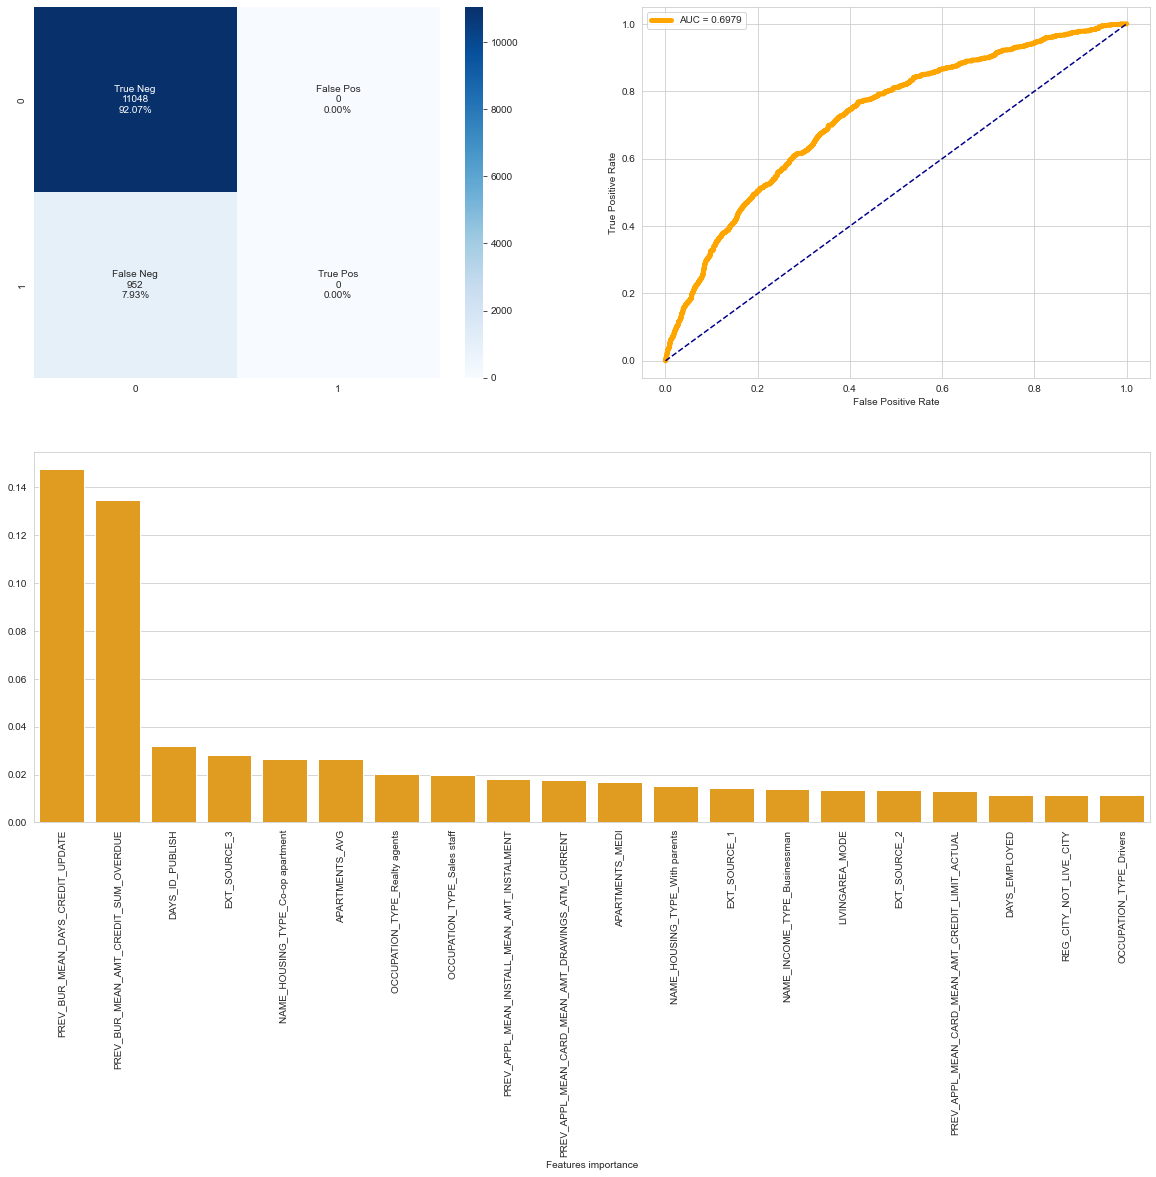

In [133]:
mrf_rfecv = RandomForestClassifier(**mrf_grid_cv.best_params_)
mrf_rfecv.fit(X_train_selected, y_train)
roc_auc_mrf = roc_auc_score(y_test, mrf_rfecv.predict_proba(X_test_selected)[:,1])
print('AUC : %0.4f' %roc_auc_mrf)
print("=="*50)
cf_matrix_roc_auc_not(mrf_rfecv, y_test, mrf_rfecv.predict(X_test_selected), mrf_rfecv.predict_proba(X_test_selected)[:,1], feature_importances=True)

AUC : 0.6527


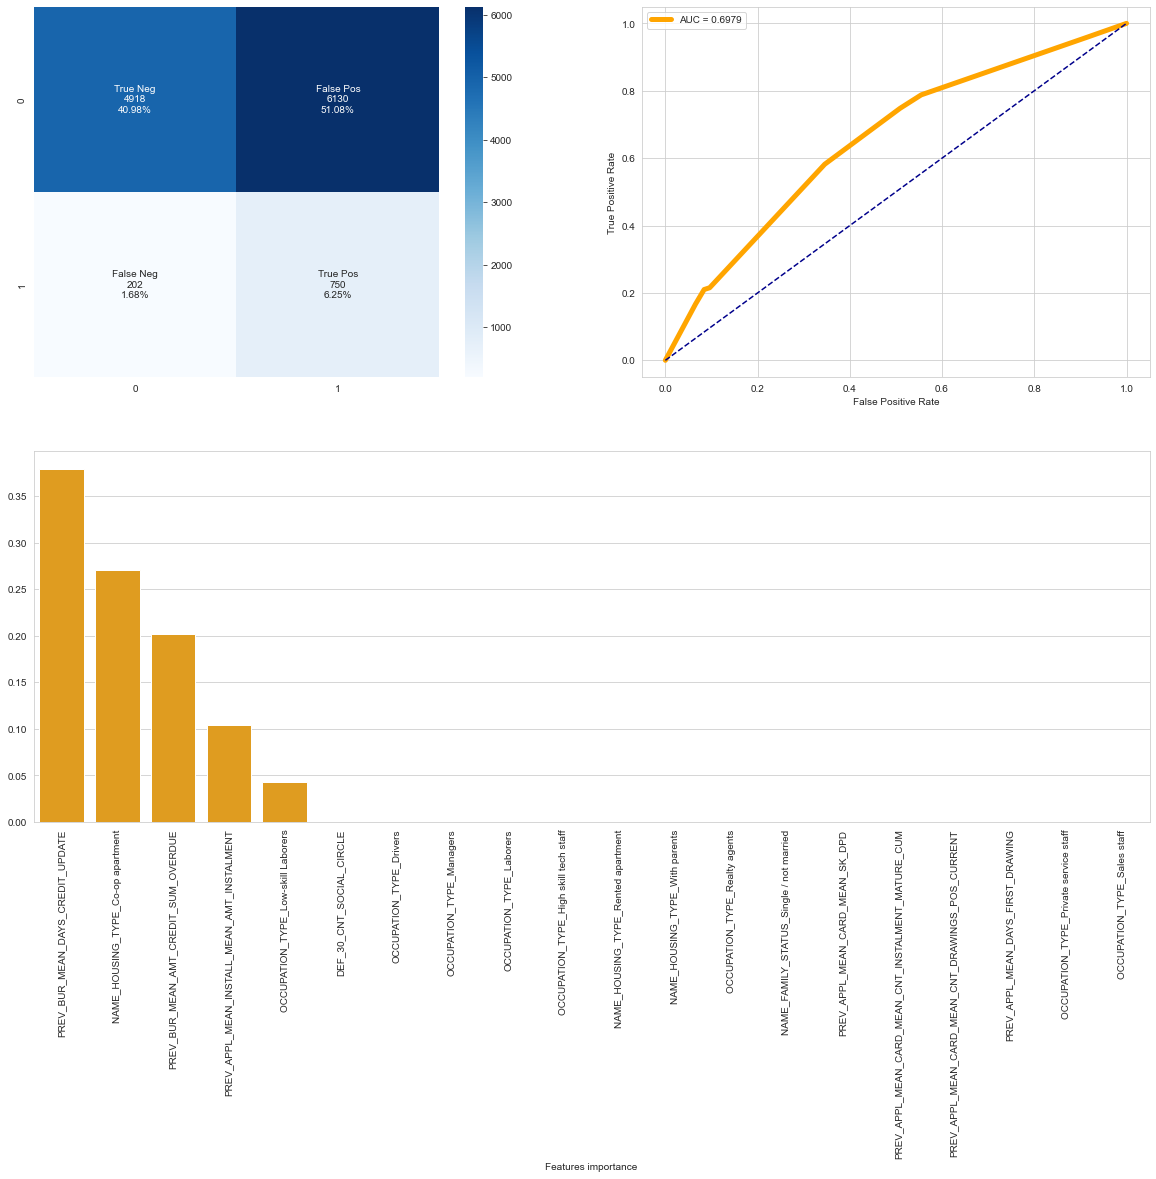

In [142]:
mdtc_rfecv = DecisionTreeClassifier(**mdtc_grid_cv.best_params_)
mdtc_rfecv.fit(X_train_selected, y_train)
roc_auc_mdtc = roc_auc_score(y_test, mdtc_rfecv.predict_proba(X_test_selected)[:,1])
print('AUC : %0.4f' %roc_auc_mdtc)
print("=="*50)
cf_matrix_roc_auc_not(mdtc_rfecv, y_test, mdtc_rfecv.predict(X_test_selected), mdtc_rfecv.predict_proba(X_test_selected)[:,1], feature_importances=True)

____

* _Cost Function_ 
___

In [143]:
#FP and FN :
print("Cost function RandomForest:")
print("=="*50)
display(classify_cost_false(mrf_rfecv, y_test, X_test_selected))
print("=="*50)
print("Cost function DecisionTree:")
display(classify_cost_false(mdtc_rfecv, y_test, X_test_selected))

Cost function RandomForest:
False Pos: 0.00%
False Neg: 7.93%


(0.0, 0.07933333333333334)

Cost function DecisionTree:
False Pos: 51.08%
False Neg: 1.68%


(0.5108333333333334, 0.016833333333333332)

<a id="6"></a>
<font color="darkblue" size=+2.5><b>6. Conclusion </b></font>


Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 2 algorithmes plus complexes. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à **`l'origine > 256`**, après **`RFECV 126`**. RandomForest ressort comme étant, le plus performant sur la métrique classique de l'AUC.

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à **0.19 (contre 0.0)**, les FN sont à **0.78 (contre 0.79)**. Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

Nous reste plus qu'a sauvegarder notre model:

In [28]:
mrf = RandomForestClassifier(**best_forest_params)
mrf.fit(X_train_selected, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=200,
                       random_state=22)

In [34]:
X_train_selected.shape


(21000, 126)

In [29]:
pickle.dump(mrf, open("./model/RandomForestClassifier.pkl", "wb"))